In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def get_data(num_threads: int, ali_size: int, single = False):
    if single:
        benchmark_file = open("data/iqtree_benchmark_single.txt", "r")
    else:
        benchmark_file = open("data/iqtree_benchmark.txt", "r")
    lines = benchmark_file.readlines()
    names = lines[0::7]
    times = [float(x.split(":")[1]) for x in lines[4::7]]
    likelihoods = [float(x.split(":")[1]) for x in lines[5::7]]
    if single:
        methods = [(x.split(".")[1]).split('_')[1] for x in names]
    else:
        methods = [x.split(".")[1] for x in names]
    tree_sizes = [int(x.split("_")[1]) for x in names]
    ali_sizes = [int(x.split("_")[2]) for x in names]
    threads = [int(x.split("_")[3].split(".")[0]) for x in names]
    data = {}

    for met, time, likeli, tree, ali, th in zip(methods, times, likelihoods, tree_sizes, ali_sizes, threads):
        if th != num_threads:
            continue
        if ali != ali_size:
            continue
        data[(met, tree)] = {
            "time": time,
            "likelihood": likeli,
        }
    if single:
        pos_tree_sizes = np.array([16, 64, 256])
    else:
        pos_tree_sizes = np.array([16, 64, 256, 1024, 4096])
    iqtree_time = np.array([data[("iqtree", ts)]["time"] for ts in pos_tree_sizes])
    phylograd_time = np.array([data[("phylograd", ts)]["time"] for ts in pos_tree_sizes])
    raxml_time = np.array([data[("raxml", ts)]["time"] for ts in pos_tree_sizes])
    iqtree_likelihood = np.array([data[("iqtree", ts)]["likelihood"] for ts in pos_tree_sizes])
    phylograd_likelihood = np.array([data[("phylograd", ts)]["likelihood"] for ts in pos_tree_sizes])
    raxml_likelihood = np.array([data[("raxml", ts)]["likelihood"] for ts in pos_tree_sizes])

    return (pos_tree_sizes, iqtree_time, phylograd_time, raxml_time,
            iqtree_likelihood, phylograd_likelihood, raxml_likelihood)


In [4]:
def create_latex_table(num_threads : int, single = False) -> str:
    header = "\\begin{table}\n\\centering\n\\begin{tabular}{|c|c|c|c|c|}\n\\hline\n"
    header += "\\textbf{Tree Size} & \\textbf{Alignment Size} & \\textbf{IQ-TREE (s)} & \\textbf{RaxML (s)} & \\textbf{PhyloGrad (s)} \\\\\n\\hline\n"
    
    if single:
        ali_sizes = [10,50]
    else:
        ali_sizes = [50,200]

    for ali_size in ali_sizes:
        pos_tree_sizes, iqtree_time, phylograd_time, raxml_time, _, _, _ = get_data(num_threads, ali_size, single)
        for size, iq, phylo, rax in zip(pos_tree_sizes, iqtree_time, phylograd_time, raxml_time):

            header += f"{size} & {ali_size} & {iq:.0f} / {iq/phylo:.2f}x & {rax:.0f} / {rax/phylo:.2f}x & {phylo:.2f} \\\\\n\\hline\n"
    header += "\\end{tabular}\n\\caption{Benchmarking of IQ-TREE and RaxML vs PhyloGrad with "+str(num_threads)+" threads}\n\\label{tab:benchmark_"+str(num_threads)+"}\n\\end{table}"
    return header

In [5]:
print(create_latex_table(num_threads = 5, single=True))

\begin{table}
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\textbf{Tree Size} & \textbf{Alignment Size} & \textbf{IQ-TREE (s)} & \textbf{RaxML (s)} & \textbf{PhyloGrad (s)} \\
\hline
16 & 10 & 0 / 0.62x & 16 / 194.38x & 0.08 \\
\hline
64 & 10 & 0 / 0.09x & 733 / 1078.13x & 0.68 \\
\hline
256 & 10 & 0 / 0.02x & 3369 / 893.71x & 3.77 \\
\hline
16 & 50 & 1 / 3.07x & 132 / 287.61x & 0.46 \\
\hline
64 & 50 & 5 / 1.54x & 5486 / 1672.56x & 3.28 \\
\hline
256 & 50 & 1247 / 69.08x & 25168 / 1394.35x & 18.05 \\
\hline
\end{tabular}
\caption{Benchmarking of IQ-TREE and RaxML vs PhyloGrad with 5 threads}
\label{tab:benchmark_5}
\end{table}


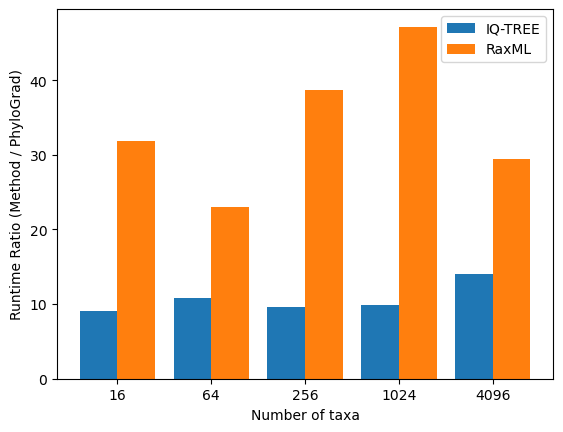

In [6]:
tree_sizes, iqtree_time, phylograd_time, raxml_time, iqtree_likelihood, phylograd_likelihood, raxml_likelihood = get_data(num_threads=1, ali_size=200)
plt.bar(np.arange(len(tree_sizes)) -0.2 , iqtree_time / phylograd_time, label="IQ-TREE", width=0.4, tick_label=tree_sizes)
plt.bar(np.arange(len(tree_sizes)) +0.2, np.clip(raxml_time / phylograd_time, a_min=None, a_max=100), label="RaxML", width=0.4, tick_label=tree_sizes)
plt.xlabel("Number of taxa")
plt.xticks(np.arange(len(tree_sizes)), tree_sizes)
plt.ylabel("Runtime Ratio (Method / PhyloGrad)")
plt.legend()
plt.show()

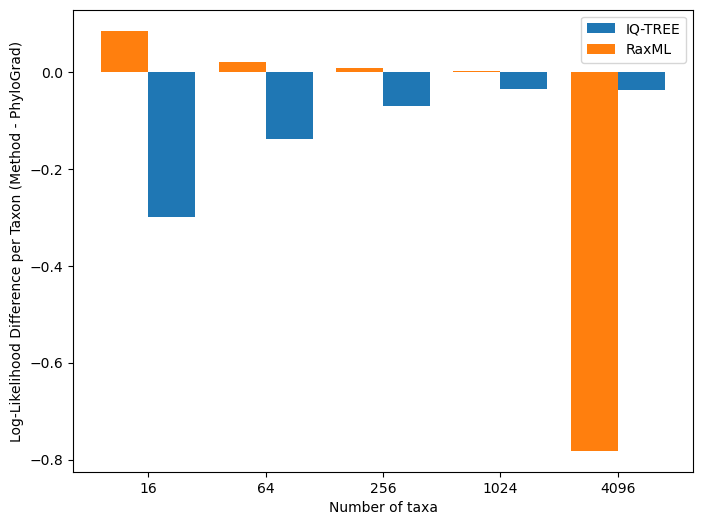

In [7]:
tree_sizes, iqtree_time, phylograd_time, raxml_time, iqtree_likelihood, phylograd_likelihood, raxml_likelihood = get_data(num_threads=1, ali_size=200)
plt.rcParams["figure.figsize"] = (8,6)
plt.bar(np.arange(len(tree_sizes)) +0.2, (iqtree_likelihood - phylograd_likelihood) / tree_sizes, label="IQ-TREE", width=0.4)
plt.bar(np.arange(len(tree_sizes)) -0.2, (raxml_likelihood - phylograd_likelihood) / tree_sizes, label="RaxML", width=0.4)
plt.xlabel("Number of taxa")
plt.xticks(np.arange(len(tree_sizes)), tree_sizes)
plt.ylabel("Log-Likelihood Difference per Taxon (Method - PhyloGrad)")
plt.legend()
plt.savefig("ll_200.pdf", bbox_inches='tight')

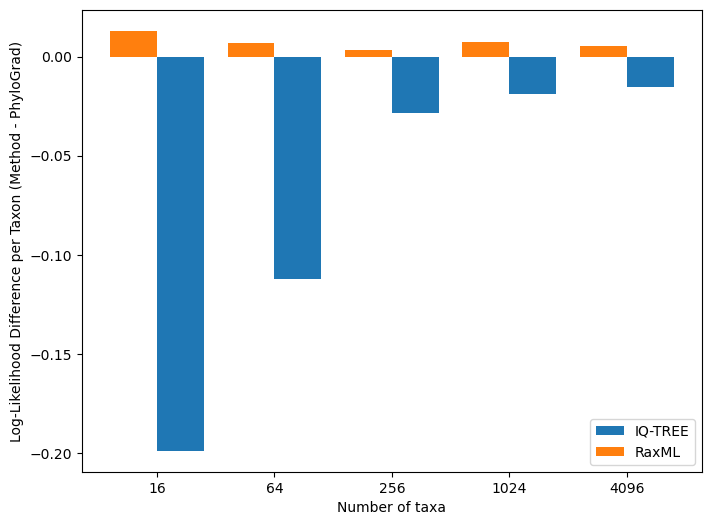

In [8]:
tree_sizes, iqtree_time, phylograd_time, raxml_time, iqtree_likelihood, phylograd_likelihood, raxml_likelihood = get_data(num_threads=1, ali_size=50)
plt.rcParams["figure.figsize"] = (8,6)
plt.bar(np.arange(len(tree_sizes)) +0.2, (iqtree_likelihood - phylograd_likelihood) / tree_sizes, label="IQ-TREE", width=0.4)
plt.bar(np.arange(len(tree_sizes)) -0.2, (raxml_likelihood - phylograd_likelihood) / tree_sizes, label="RaxML", width=0.4)
plt.xlabel("Number of taxa")
plt.xticks(np.arange(len(tree_sizes)), tree_sizes)
plt.ylabel("Log-Likelihood Difference per Taxon (Method - PhyloGrad)")
plt.legend()
plt.savefig("ll_50.pdf", bbox_inches='tight')

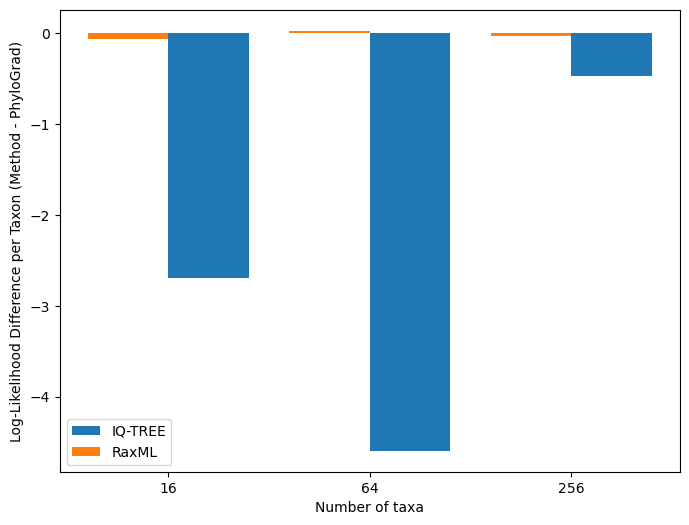

In [11]:
tree_sizes, iqtree_time, phylograd_time, raxml_time, iqtree_likelihood, phylograd_likelihood, raxml_likelihood = get_data(num_threads=1, ali_size=10, single=True)
plt.rcParams["figure.figsize"] = (8,6)
plt.bar(np.arange(len(tree_sizes)) +0.2, (iqtree_likelihood - phylograd_likelihood) / tree_sizes, label="IQ-TREE", width=0.4)
plt.bar(np.arange(len(tree_sizes)) -0.2, (raxml_likelihood - phylograd_likelihood) / tree_sizes, label="RaxML", width=0.4)
plt.xlabel("Number of taxa")
plt.xticks(np.arange(len(tree_sizes)), tree_sizes)
plt.ylabel("Log-Likelihood Difference per Taxon (Method - PhyloGrad)")
plt.legend()
plt.savefig("ll_single10.pdf", bbox_inches='tight')